In [ ]:
import gc
import os
import math
import numpy as np
import pandas as pd
from numba import njit
from numpy import sqrt, sin, cos, pi, zeros
from numpy.random import randn, rand, uniform, normal
from scipy.linalg import hadamard
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Activation, LSTM, Dropout, RepeatVector, TimeDistributed, Embedding, Reshape, Dot, Concatenate
from tensorflow.keras.layers import GRU, SpatialDropout1D, Conv1D, GlobalMaxPooling1D,Multiply, Lambda, Softmax, Flatten, BatchNormalization, Bidirectional, dot, concatenate
from tensorflow.keras.layers import AdditiveAttention, Attention
from tensorflow.keras.activations import relu
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks
from tensorflow.keras import backend
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import MeanSquaredError
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

Tensorflow version 2.8.0


In [ ]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [ ]:
MIXED_PRECISION = False
XLA_ACCELERATE = True

if MIXED_PRECISION:
    from tensorflow.keras.mixed_precision import experimental as mixed_precision
    if tpu: policy = tf.keras.mixed_precision.experimental.Policy('mixed_bfloat16')
    else: policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
    mixed_precision.set_policy(policy)
    print('Mixed precision enabled')

if XLA_ACCELERATE:
    tf.config.optimizer.set_jit(True)
    print('Accelerated Linear Algebra enabled')

Accelerated Linear Algebra enabled


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
lotto = pd.read_csv('/content/With-bonus.csv', index_col = 'Date')
print(lotto)

           Ball 1  Ball 2  Ball 3  Ball 4  Ball 5  Ball 6  Ball 7  Ball 8  \
Date                                                                        
13/3/2022       2       5       9      12      14      17      31      35   
3/12/2022       2       5      14      20      21      25      29      35   
3/9/2022        6       9      15      16      23      25      26      32   
3/6/2022        1       3       4      12      17      24      25      29   
3/5/2022        5       7      13      18      28      31      34      35   
...           ...     ...     ...     ...     ...     ...     ...     ...   
1/11/2020       5      12      13      15      23      30      32      34   
1/8/2020        2       4       8      10      12      19      22      36   
1/5/2020        3       4       5       7      11      23      24      26   
1/4/2020        8      12      14      15      19      22      23      30   
1/1/2020        3       7      10      12      14      28      29      31   

In [ ]:
data = lotto.values
train = data[:-50]
test = data[-50:]

w = 10
X_train = []
y_train = []
for i in range(w, len(train)):
    X_train.append(train[i - w: i, :])
    y_train.append(train[i])
X_train, y_train = np.array(X_train), np.array(y_train)

inputs = data[data.shape[0] - test.shape[0] - w:]
X_test = []
for i in range(w, inputs.shape[0]):
    X_test.append(inputs[i - w: i, :])
X_test = np.array(X_test)
y_test = test

In [ ]:
print(data.shape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(286, 10)
(226, 10, 10)
(226, 10)
(50, 10, 10)
(50, 10)


In [ ]:
embed_dim = (35 // 2)
dropout_rate = 0.5
spatial_dropout_rate = 0.5
steps_before = w
steps_after = 7
feature_count = embed_dim * 7
hidden_neurons = [64, 32]
bidirectional = True
attention_style = 'Bahdanau'

In [ ]:
with strategy.scope():

    inp0 = Input(shape = (w, X_train.shape[2]))

    # Embed 36 categories into a 30-dimension continuous-number vector for each ball
    inp1 = Lambda(lambda x: x[:, :, 0])(inp0)
    inp1 = Embedding(35, embed_dim)(inp1)
    inp1 = SpatialDropout1D(spatial_dropout_rate)(inp1)

    inp2 = Lambda(lambda x: x[:, :, 1])(inp0)
    inp2 = Embedding(35, embed_dim)(inp2)
    inp2 = SpatialDropout1D(spatial_dropout_rate)(inp2)

    inp3 = Lambda(lambda x: x[:, :, 2])(inp0)
    inp3 = Embedding(35, embed_dim)(inp3)
    inp3 = SpatialDropout1D(spatial_dropout_rate)(inp3)

    inp4 = Lambda(lambda x: x[:, :, 3])(inp0)
    inp4 = Embedding(35, embed_dim)(inp4)
    inp4 = SpatialDropout1D(spatial_dropout_rate)(inp4)

    inp5 = Lambda(lambda x: x[:, :, 4])(inp0)
    inp5 = Embedding(35, embed_dim)(inp5)
    inp5 = SpatialDropout1D(spatial_dropout_rate)(inp5)

    inp6 = Lambda(lambda x: x[:, :, 5])(inp0)
    inp6 = Embedding(35, embed_dim)(inp6)
    inp6 = SpatialDropout1D(spatial_dropout_rate)(inp6)

    inp7 = Lambda(lambda x: x[:, :, 6])(inp0)
    inp7 = Embedding(35, embed_dim)(inp7)
    inp7 = SpatialDropout1D(spatial_dropout_rate)(inp7)

    inp = Concatenate()([inp1, inp2, inp3, inp4, inp5, inp6, inp7])

    # Seq2Seq model with attention or bidirectional encoder

    num_layers = len(hidden_neurons)

    sh_list, h_list, c_list = [inp], [], []

    if bidirectional:

        for i in range(num_layers):

            sh, fh, fc, bh, bc = Bidirectional(LSTM(hidden_neurons[i],
                                                    dropout = dropout_rate,
                                                    return_state = True,
                                                    return_sequences = True))(sh_list[-1])

            h = Concatenate()([fh, bh])
            c = Concatenate()([fc, bc])

            sh_list.append(sh)
            h_list.append(h)
            c_list.append(c)

    else:

        for i in range(num_layers):

            sh, h, c = LSTM(hidden_neurons[i],
                            dropout = dropout_rate,
                            return_state = True,
                            return_sequences = True)(sh_list[-1])

            sh_list.append(sh)
            h_list.append(h)
            c_list.append(c)

    decoder = RepeatVector(steps_after)(h_list[-1])

    if bidirectional:

        decoder_hidden_neurons = [hn * 2 for hn in hidden_neurons]

    else:

        decoder_hidden_neurons = hidden_neurons

    for i in range(num_layers):

        decoder = LSTM(decoder_hidden_neurons[i],
                       dropout = dropout_rate,
                       return_sequences = True)(decoder, initial_state = [h_list[i], c_list[i]])

    if attention_style == 'Bahdanau':

        context = AdditiveAttention(dropout = dropout_rate)([decoder, sh_list[-1]])

        decoder = concatenate([context, decoder])

    elif attention_style == 'Luong':

        context = Attention(dropout = dropout_rate)([decoder, sh_list[-1]])

        decoder = concatenate([context, decoder])

    out = Dense(36, activation = 'softmax')(decoder)

    model = Model(inputs = inp0, outputs = out)

    sparse_top_k = tf.keras.metrics.SparseTopKCategoricalAccuracy(k = 5, name = 'sparse_top_k')

    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = [sparse_top_k])

In [ ]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 10, 10)]     0           []                               
                                                                                                  
 lambda_28 (Lambda)             (None, 10)           0           ['input_5[0][0]']                
                                                                                                  
 lambda_29 (Lambda)             (None, 10)           0           ['input_5[0][0]']                
                                                                                                  
 lambda_30 (Lambda)             (None, 10)           0           ['input_5[0][0]']                
                                                                                            

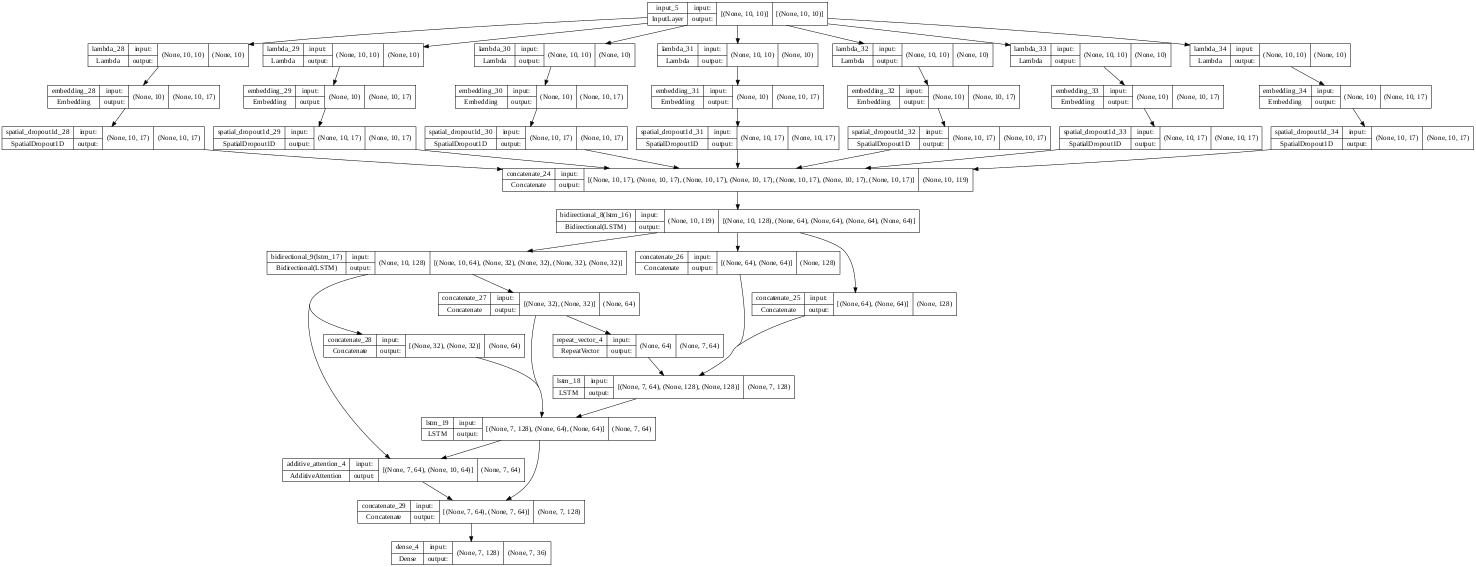

In [ ]:
plot_model(model, show_shapes = True, show_layer_names = True, rankdir = 'TB', dpi = 36)

In [ ]:
class CosineAnnealingScheduler(callbacks.Callback):
    """Cosine annealing scheduler.
    """

    def __init__(self, T_max, eta_max, eta_min = 0, verbose = 0):
        super(CosineAnnealingScheduler, self).__init__()
        self.T_max = T_max
        self.eta_max = eta_max
        self.eta_min = eta_min
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs = None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = self.eta_min + (self.eta_max - self.eta_min) * (1 + math.cos(math.pi * epoch / self.T_max)) / 2
        backend.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nEpoch %05d: CosineAnnealingScheduler setting learning '
                  'rate to %s.' % (epoch + 1, lr))

    def on_epoch_end(self, epoch, logs = None):
        logs = logs or {}
        logs['lr'] = backend.get_value(self.model.optimizer.lr)

In [ ]:
EPOCHS = 200
BATCH_SIZE = 32
LR_MAX = 1e-4
LR_MIN = 1e-5

cas = CosineAnnealingScheduler(EPOCHS, LR_MAX, LR_MIN)

ckp = callbacks.ModelCheckpoint('best_model.hdf5', monitor = 'val_sparse_top_k', verbose = 0,
                                save_best_only = True, save_weights_only = False, mode = 'max')

history = model.fit(X_train, y_train,
                    validation_data = (X_test, y_test),
                    callbacks = [ckp, cas],
                    epochs = EPOCHS,
                    batch_size = BATCH_SIZE,
                    verbose = 2)

hist = pd.DataFrame(history.history)

Epoch 1/200


InvalidArgumentError: ignored